In [2]:
from binance.client import Client
import pandas as pd
import matplotlib.pyplot as plt

In [5]:

# Initialize the Binance client
client = Client()

In [6]:
# Fetch historical funding rates
funding_rates = client.futures_funding_rate(symbol='BTCUSDT', limit=500)


In [7]:
funding_rates

[{'symbol': 'BTCUSDT',
  'fundingTime': 1700611200000,
  'fundingRate': '0.00010000',
  'markPrice': '35745.39198625'},
 {'symbol': 'BTCUSDT',
  'fundingTime': 1700640000000,
  'fundingRate': '0.00010000',
  'markPrice': '36435.97590206'},
 {'symbol': 'BTCUSDT',
  'fundingTime': 1700668800000,
  'fundingRate': '0.00010000',
  'markPrice': '36480.85577320'},
 {'symbol': 'BTCUSDT',
  'fundingTime': 1700697600000,
  'fundingRate': '0.00010000',
  'markPrice': '37411.23448797'},
 {'symbol': 'BTCUSDT',
  'fundingTime': 1700726400000,
  'fundingRate': '0.00010000',
  'markPrice': '37378.50000000'},
 {'symbol': 'BTCUSDT',
  'fundingTime': 1700755200001,
  'fundingRate': '0.00010000',
  'markPrice': '36954.00000000'},
 {'symbol': 'BTCUSDT',
  'fundingTime': 1700784000000,
  'fundingRate': '0.00010000',
  'markPrice': '37294.40000000'},
 {'symbol': 'BTCUSDT',
  'fundingTime': 1700812800000,
  'fundingRate': '0.00010000',
  'markPrice': '37530.00000000'},
 {'symbol': 'BTCUSDT',
  'fundingTime': 

In [8]:
# Convert to DataFrame
funding_df = pd.DataFrame(funding_rates)
funding_df['fundingTime'] = pd.to_datetime(funding_df['fundingTime'], unit='ms')
funding_df['fundingTime']=funding_df['fundingTime'].round('s')
funding_df.set_index('fundingTime', inplace=True)

print(funding_df.shape)
print(funding_df.dtypes)

(500, 3)
symbol         object
fundingRate    object
markPrice      object
dtype: object


In [9]:
#Give correct type
funding_df['fundingRate'] = funding_df['fundingRate'].astype(float)
funding_df['symbol'] = funding_df['symbol'].astype(str)
funding_df['markPrice'] = pd.to_numeric(funding_df['markPrice'], errors='coerce')
print(funding_df.head())
print(funding_df.tail())
print(funding_df.describe())


                      symbol  fundingRate     markPrice
fundingTime                                            
2023-11-22 00:00:00  BTCUSDT       0.0001  35745.391986
2023-11-22 08:00:00  BTCUSDT       0.0001  36435.975902
2023-11-22 16:00:00  BTCUSDT       0.0001  36480.855773
2023-11-23 00:00:00  BTCUSDT       0.0001  37411.234488
2023-11-23 08:00:00  BTCUSDT       0.0001  37378.500000
                      symbol  fundingRate     markPrice
fundingTime                                            
2024-05-05 00:00:00  BTCUSDT     0.000069  63864.200000
2024-05-05 08:00:00  BTCUSDT     0.000006  63702.808475
2024-05-05 16:00:00  BTCUSDT     0.000039  64398.100000
2024-05-06 00:00:00  BTCUSDT     0.000006  63988.000000
2024-05-06 08:00:00  BTCUSDT    -0.000010  64510.209348
       fundingRate     markPrice
count   500.000000    500.000000
mean      0.000169  53011.772610
std       0.000150  11674.351232
min      -0.000038  35745.391986
25%       0.000100  42720.519513
50%       0.000100

In [10]:
# Fetch historical price data for BTCUSDT spot and future
klines = client.get_historical_klines("BTCUSDT", Client.KLINE_INTERVAL_8HOUR, funding_df.index[0].strftime('%Y-%m-%d %H:%M:%S'))
klines_future= client.futures_historical_klines("BTCUSDT", Client.KLINE_INTERVAL_8HOUR, funding_df.index[0].strftime('%Y-%m-%d %H:%M:%S'))

In [11]:
def klines_toDf(klines):
    """
    Convert list of klines to a pandas DataFrame.

    :param klines: A list of klines data.
    :type klines: list
    :return: A pandas DataFrame with columns ['Open Time', 'Open', 'Close', 'Volume'].
    :rtype: pandas.DataFrame
    """
    prices_df = pd.DataFrame(klines, columns=[
        'Open Time', 
        'Open', 
        'High', 
        'Low', 
        'Close', 
        'Volume', 
        'Close Time', 
        'Quote Asset Volume', 
        'Number of Trades', 
        'Taker Buy Base Asset Volume', 
        'Taker Buy Quote Asset Volume', 
        'Ignore'
    ])
    
    prices_df = prices_df[['Open Time', 'Open', 'Close', 'Volume']]
    
    # Convert time from milliseconds to a readable date format
    prices_df['Open Time'] = pd.to_datetime(prices_df['Open Time'], unit='ms')
    prices_df.set_index('Open Time', inplace=True)
    # Convert 'Open', 'Close', and 'Volume' to float
    prices_df['Open'] = prices_df['Open'].astype(float)
    prices_df['Close'] = prices_df['Close'].astype(float)
    prices_df['Volume'] = prices_df['Volume'].astype(float)
    
    # Now apply rounding
    prices_df = prices_df.round(decimals=4)
    
    # Check the changes
    print(prices_df.head())
    print(prices_df.tail())
    print(prices_df.dtypes)
    print(prices_df.shape)
    return prices_df

In [12]:
# Convert the spot and future kline data to dataframes
price_df_spot = klines_toDf(klines)
price_df_futur = klines_toDf(klines_future)

# Rename the 'Open' column in both dataframes for clarity
price_df_spot = price_df_spot.rename(columns={'Open': 'Open BTCUSDT_SPOT'})
price_df_futur = price_df_futur.rename(columns={'Open': 'Open BTCUSDT_PERP'})

# Concatenate the two dataframes along the column axis
prices_df = pd.concat([price_df_spot['Open BTCUSDT_SPOT'], price_df_futur['Open BTCUSDT_PERP']], axis=1)

# Display the resulting dataframe
prices_df

                         Open     Close      Volume
Open Time                                          
2023-11-22 00:00:00  35741.65  36439.81  12691.8474
2023-11-22 08:00:00  36439.80  36481.14  11299.0663
2023-11-22 16:00:00  36481.15  37408.34  21060.3932
2023-11-23 00:00:00  37408.35  37369.21   6814.5111
2023-11-23 08:00:00  37369.22  36951.34  11339.3396
                         Open     Close     Volume
Open Time                                         
2024-05-05 00:00:00  63892.03  63736.87  6008.7678
2024-05-05 08:00:00  63736.86  64428.65  7837.1736
2024-05-05 16:00:00  64428.64  64012.00  4680.8088
2024-05-06 00:00:00  64012.00  64540.75  7291.5704
2024-05-06 08:00:00  64540.75  64294.05  9458.7087
Open      float64
Close     float64
Volume    float64
dtype: object
(500, 3)
                        Open    Close      Volume
Open Time                                        
2023-11-22 00:00:00  35737.0  36430.7   82891.616
2023-11-22 08:00:00  36430.7  36480.5   92847.291
20

,Open BTCUSDT_SPOT,Open BTCUSDT_PERP
Open Time,,
2023-11-22 00:00:00,35741.65,35737.0
2023-11-22 08:00:00,36439.80,36430.7
2023-11-22 16:00:00,36481.15,36480.6
2023-11-23 00:00:00,37408.35,37413.5
2023-11-23 08:00:00,37369.22,37378.5
...,...,...
2024-05-05 00:00:00,63892.03,63864.3
2024-05-05 08:00:00,63736.86,63697.1
2024-05-05 16:00:00,64428.64,64398.1


In [13]:
#Merge the prices with the funding and Mark price
data2 = pd.concat([prices_df,funding_df['fundingRate'],funding_df['markPrice']],axis=1)
data2['cumulative funding rate'] = data2['fundingRate'].cumsum()

In [14]:
data2.shape

(500, 5)

In [15]:
data2.tail()


,Open BTCUSDT_SPOT,Open BTCUSDT_PERP,fundingRate,markPrice,cumulative funding rate
2024-05-05 00:00:00,63892.03,63864.3,0.000069,63864.200000,0.084333
2024-05-05 08:00:00,63736.86,63697.1,0.000006,63702.808475,0.084339
2024-05-05 16:00:00,64428.64,64398.1,0.000039,64398.100000,0.084378
2024-05-06 00:00:00,64012.00,63987.9,0.000006,63988.000000,0.084384
2024-05-06 08:00:00,64540.75,64509.5,-0.000010,64510.209348,0.084374


In [16]:
data2.describe()

,Open BTCUSDT_SPOT,Open BTCUSDT_PERP,fundingRate,markPrice,cumulative funding rate
count,500.000000,500.000000,500.000000,500.000000,500.000000
mean,52998.772060,53013.234600,0.000169,53011.772610,0.041854
std,11664.314002,11675.515789,0.000150,11674.351232,0.027881
min,35741.650000,35737.000000,-0.000038,35745.391986,0.000100
25%,42713.260000,42721.875000,0.000100,42720.519513,0.021967
50%,49769.265000,49770.650000,0.000100,49769.596335,0.034113
75%,64633.632500,64653.975000,0.000202,64651.346828,0.070048
max,73224.000000,73280.700000,0.000881,73280.700000,0.084384


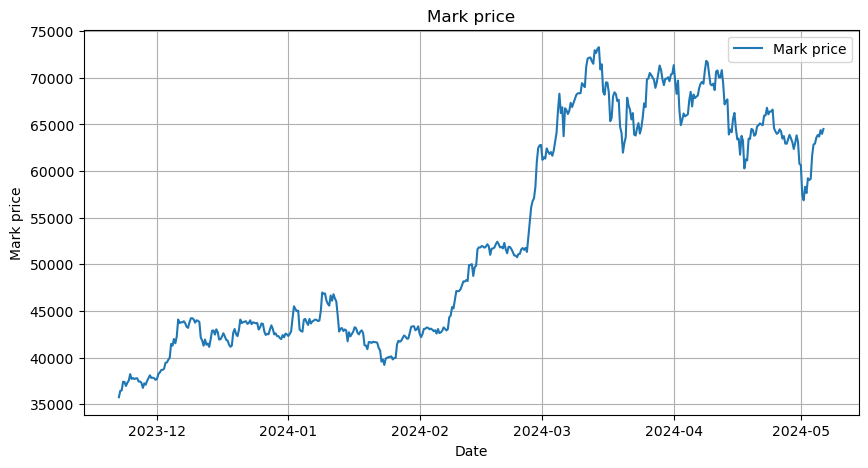

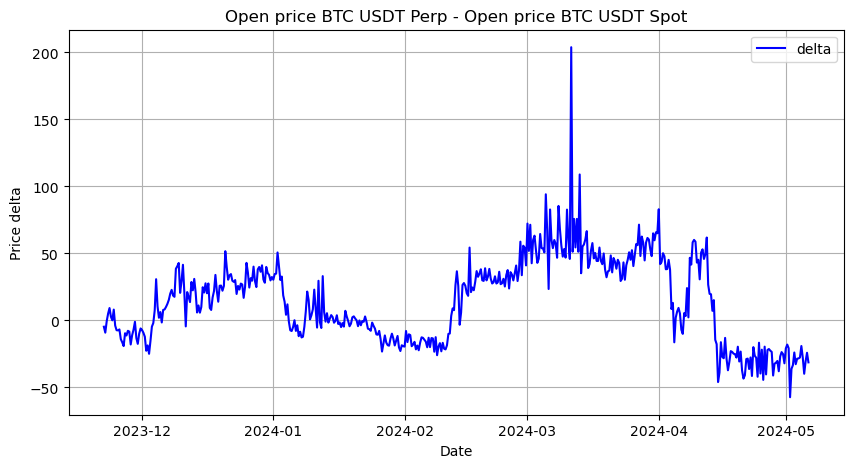

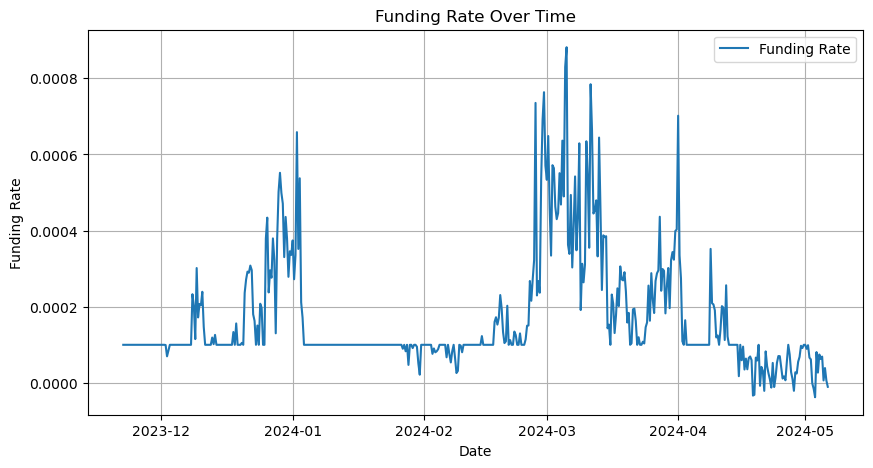

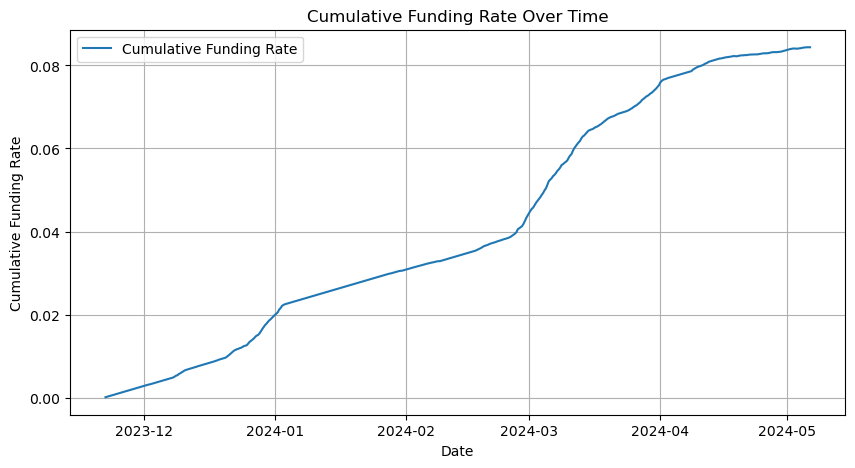

In [17]:
# Plotting Mark prices
plt.figure(figsize=(10, 5))  # Set the figure size as desired
plt.plot(data2.index, data2['markPrice'],label = 'Mark price')
plt.title('Mark price')  # Title of the plot
plt.xlabel('Date')  # Label for the x-axis
plt.ylabel('Mark price')  # Label for the y-axis
plt.grid(True)  # Add gridlines for better readability
plt.legend()  # Add a legend if necessary
plt.show()  # Display the plot

#Plotting the price difference between Future and Spot on Binance perpetual 
plt.figure(figsize=(10, 5))
plt.plot(prices_df.index, prices_df['Open BTCUSDT_PERP']-prices_df['Open BTCUSDT_SPOT'], color='blue', label= 'delta')
plt.title('Open price BTC USDT Perp - Open price BTC USDT Spot')
plt.xlabel('Date')
plt.ylabel('Price delta')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the funding rate
plt.figure(figsize=(10, 5))  # Set the figure size as desired
plt.plot(data2.index, data2['fundingRate'], label='Funding Rate')
plt.title('Funding Rate Over Time')  # Title of the plot
plt.xlabel('Date')  # Label for the x-axis
plt.ylabel('Funding Rate')  # Label for the y-axis
plt.grid(True)  # Add gridlines for better readability
plt.legend()  # Add a legend if necessary
plt.show()  # Display the plot

# Plotting the cumulative funding rate
plt.figure(figsize=(10, 5))  # Set the figure size as desired
plt.plot(data2.index, data2['cumulative funding rate'], label='Cumulative Funding Rate')
plt.title('Cumulative Funding Rate Over Time')  # Title of the plot
plt.xlabel('Date')  # Label for the x-axis
plt.ylabel('Cumulative Funding Rate')  # Label for the y-axis
plt.grid(True)  # Add gridlines for better readability
plt.legend()  # Add a legend
plt.show()  # Display the plot


In [18]:
data2.to_csv('data\Bitcoin')